# Importing dependencies

In [0]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Loading dataset

In [0]:
from google.colab import files
files.upload()

In [5]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d fpeccia/weed-detection-in-soybean-crops
!unzip -q weed-detection-in-soybean-crops.zip
!rm -rf weed-detection-in-soybean-crops.zip
!rm -rf ~/.kaggle/

100% 2.36G/2.37G [00:46<00:00, 93.4MB/s]
100% 2.37G/2.37G [00:46<00:00, 54.1MB/s]


In [0]:
image_dir = r'./dataset/dataset/'
classes = classes = [_class for _class in os.listdir(image_dir)]

num_images = 999999
for _class in classes:
  i = len(glob.glob(image_dir+_class+'/*.tif'))
  if i < num_images:
    num_images = i

img_files = [] 
labels = np.zeros(num_images*len(classes))


for i, _class in enumerate(classes):
    img_files += [img for img in glob.glob(image_dir+_class+'/*.tif')][:num_images]
    labels[i*num_images:(i+1)*num_images] = i

# Preprocessing

In [0]:
width = 200
height = 200
channel = 3
dim = width * height * channel

X = np.ndarray(shape=(len(img_files), width, height, channel), dtype=np.float64)

for i, file in enumerate(img_files):
    X[i] = cv2.resize(cv2.imread(file), (width, height))

X = np.reshape(X, (X.shape[0], -1)).astype('float64')
X -= 128

# Splitting data

In [0]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, labels, train_size=0.8, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_tmp, y_tmp, train_size=0.5, shuffle=True, random_state=42)

# Visualizing samples

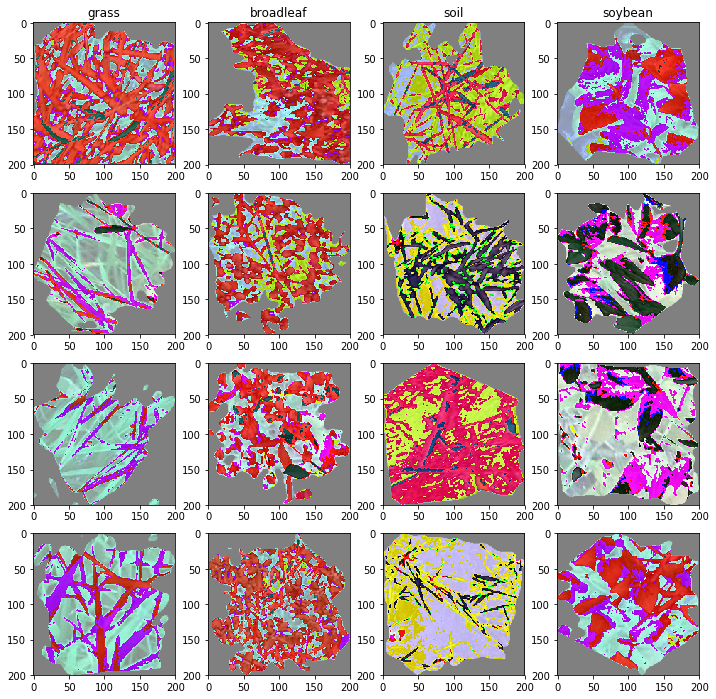

In [9]:
n_class = len(classes)
samples_per_class = 4


for y, _class in enumerate(classes):
    idxes = np.flatnonzero(y == y_train)
    idxes = np.random.choice(idxes, samples_per_class, replace = False)
    for i, idx in enumerate(idxes):
        plt_idx = i * n_class + y + 1
        plt.subplot(samples_per_class,n_class, plt_idx)
        plt.imshow(X_train[idx].reshape(width, height, channel).astype('uint8'))
        if(i==0): plt.title(_class)

plt.show()


# Neural net
source: https://www.kaggle.com/datduyn/2-layer-net-on-weeds-discriminant/

In [0]:
class TwoLayerNet():
    def __init__(self, input_size, hidden_size, output_size, std= 1e-4):
        '''
        std: weight initialization term
        W1: first layer weight, shape(D x H) 
        W2: second layer weight shape(H x C) 
        C: num_classes(output_size) , H: hidden_size, D: data_dim(input_size) 
        '''
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y = None, reg=0.0):
        '''
        reg: regularization strength
        X: ndarray shape(N x C). N: num of data 
        y: vector of training label
        '''
        #DEfine relu activation function 
        relu = lambda x:np.maximum(0,x)

        #unpack
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #Forward prop
        layer1 = relu(X.dot(W1) + b1)  #(N,D) x (D,H) = (N,H)
        scores = layer1.dot(W2) + b2

        #if target is not given then jump out 
        if(y is None): 
            return scores

        #compute the loss 
        ##Normalization trick to prevent overflow when compute exp 
        scores -= scores.max()#stack vertically

        scores = np.exp(scores)
        scores_sumexp = np.sum(scores, axis=1)#stack vertically

        ##Nomalize all score 
        softmax = scores / scores_sumexp.reshape(N,1)  #Shape: (N, C)
        #total loss of all training. -log of all correct score
        loss =  (-1.0) * np.sum(np.log(softmax[range(N),y]))

        ##Normalize the loss and add regularization strength 
        loss /= N 
        loss += reg * np.sum(W1 * W1) 
        loss += reg * np.sum(W2 * W2) 

        #Backward pass on the net 
        grads = {}

        correct_class_scores = scores[range(N), y]
        softmax[range(N), y] = (-1.0) * (scores_sumexp - correct_class_scores)/scores_sumexp
        softmax /= N


        #Want to find dW2(dL/dW2)
        # Derivation: dL/dW2 = dL/dscore * dscore/dW2(chain rule)
        #dL/dscore = softmax since L(score) = softmax(variable)
        #dscore/dW2 = relu_(hidden layer output)
        grads['W2'] = layer1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)#stack horizontally
        grads['W2'] += reg * 2 * W2

        #dL/dW1 = dL/dscore * dscore/drelu(layler1) * drelu(layer1)/dW1 
        #dL/dW1 = dW1 = softmax * W2 * X 
        hidden = softmax.dot(W2.T)

        #derivative of a max gate
        #Intuition: in forward pass if neuron didn't fire that mean. the derivative of that neuron 
        # is 0. This might be bad since this will kill gradient. 
        hidden[layer1 == 0] = 0 

        grads['W1'] = X.T.dot(hidden) 
        grads['b1'] = np.sum(hidden, axis=0) #stack horizontally 
        grads['W1'] += reg * 2 * W1

        return loss, grads

    def train(self, X, y, X_val, y_val, 
              learning_rate =1e-3, learning_rate_decay=0.95, 
              reg=5e-6, num_iters=100, 
              batch_size=200, it_verbose = 1, verbose=False):
        '''
        Train using SGD 
        Input: 
            X: nd array shape(N x D) 
            y: vector of train label 
            X_val: nd array shape( n_VAL , D) Use as validation set after each epoch 
            y_val: vector of validation label 
        '''
        N, D = X.shape
        N_val = X_val.shape[0]
        iteration_per_epoch = max(N/batch_size, 1)
        
        loss_hist = []
        train_acc_hist = []
        val_acc_hist = []
        
        for it in range(num_iters):
            sampling = np.random.choice(np.arange(N), batch_size, replace=False) 
            X_batch = X[sampling]
            y_batch = y[sampling]
            
            #compute loss and gradients
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_hist.append(loss) 
            
            #Update rule 
            self.params['W1'] += (-1.0) * learning_rate * grads['W1']
            self.params['b1'] += (-1.0) * learning_rate * grads['b1']
            self.params['W2'] += (-1.0) * learning_rate * grads['W2']
            self.params['b2'] += (-1.0) * learning_rate * grads['b2']
            
            if(verbose and it%it_verbose==0):
                print('iteration: %d / %d | Loss: %f' % (it, num_iters, loss)) 
            # Every epoch, check train and val accuracy and decay learning rate.
            if (it % iteration_per_epoch == 0):
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_hist.append(train_acc)
                val_acc_hist.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay
        return {
            'loss_hist':loss_hist,
            'train_acc_hist':train_acc_hist,
            'val_acc_hist':val_acc_hist
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
        classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
        the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
        to have class c, where 0 <= c < C.
        """
        y_pred = None
        relu = lambda x:np.maximum(0,x)
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']

        #Forward propagation though the network 
        layer1 = relu(X.dot(W1) + b1)
        scores = layer1.dot(W2) + b2 #shape: (N x C)
        y_pred = np.argmax(scores, axis=1)

        return y_pred

# Trainning

In [16]:
X_dev = X_train.astype('float64')
y_dev = y_train.astype(int)

input_size = width * height * channel
hidden_size = 128
output_size = n_class 
num_iter = 1000
lr =1e-5
std = 1e-3 
lr_decay=0.93
regularization = 0.0
verbose = True
batch_size=256
it_verbose = num_iter // 10


net = TwoLayerNet(input_size, hidden_size,output_size,std )
stats = net.train(X_dev, y_dev, X_val, y_val, 
              learning_rate =lr, learning_rate_decay=lr_decay, 
              reg=regularization, num_iters=num_iter, 
              batch_size=batch_size, it_verbose = it_verbose, verbose=verbose)

train_acc = stats['train_acc_hist'][-1]
val_acc = stats['val_acc_hist'][-1]
print('hs:',hidden_size,'learn:',lr,'reg',regularization,'iter',num_iter,'train-acc:',train_acc,'val_acc',val_acc)


iteration: 0 / 1000 | Loss: 1.400986
iteration: 100 / 1000 | Loss: 1.071542
iteration: 200 / 1000 | Loss: 0.798855
iteration: 300 / 1000 | Loss: 0.685602
iteration: 400 / 1000 | Loss: 0.688825
iteration: 500 / 1000 | Loss: 0.632806
iteration: 600 / 1000 | Loss: 0.639522
iteration: 700 / 1000 | Loss: 0.558338
iteration: 800 / 1000 | Loss: 0.579838
iteration: 900 / 1000 | Loss: 0.613904
hs: 128 learn: 1e-05 reg 0.0 iter 1000 train-acc: 0.3046875 val_acc 0.2647058823529412


In [17]:
vl_score = net.predict(X_test)
print(classification_report(y_test, vl_score, target_names=classes))

              precision    recall  f1-score   support

       grass       0.56      0.53      0.54       133
   broadleaf       0.61      0.72      0.66       100
        soil       0.96      1.00      0.98       113
     soybean       0.69      0.62      0.65       131

    accuracy                           0.70       477
   macro avg       0.71      0.72      0.71       477
weighted avg       0.70      0.70      0.70       477



(array([124.,   0.,   0., 118.,   0.,   0., 118.,   0.,   0., 117.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

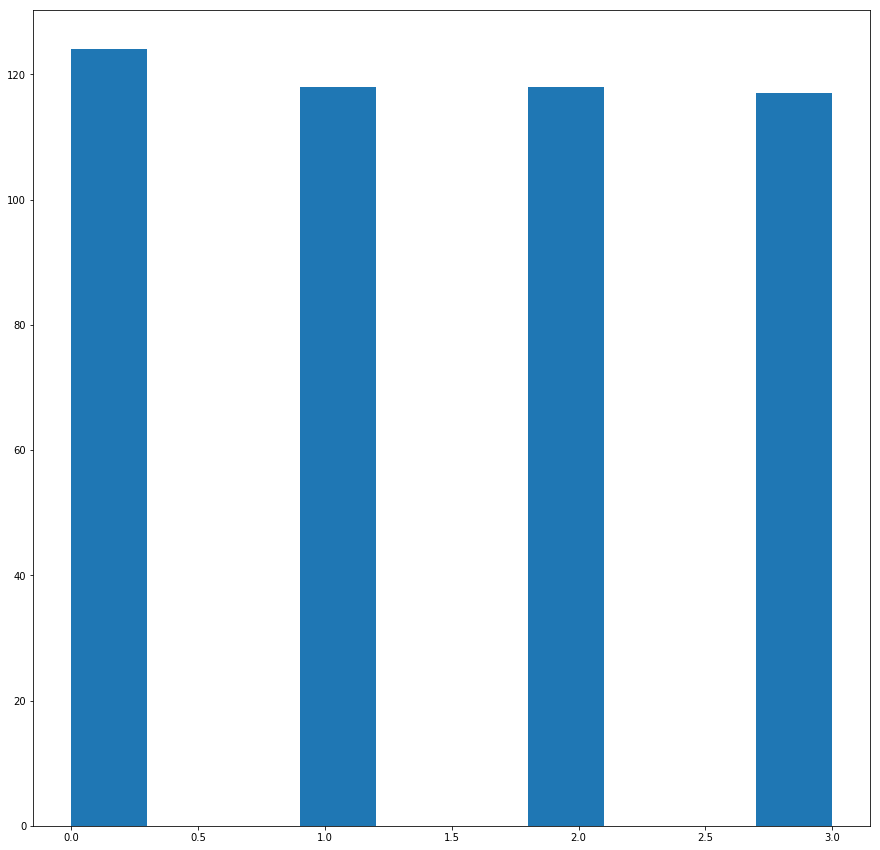

In [18]:
plt.hist(net.predict(X_test))